In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.base import clone
from themis_ml.metrics import mean_difference
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hmda14a = pd.read_csv('hmda14a.csv')
hmda14b = pd.read_csv('hmda14b.csv')
hmda14c = pd.read_csv('hmda14c.csv')

print ("hmda14a", hmda14a.shape)
list_ = []
list_.append(hmda14a)
list_.append(hmda14b)
list_.append(hmda14c)

frame2 = pd.concat(list_, axis = 0, ignore_index = True)
print ("frame:", frame2.shape)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (1,41,43,45,47,49,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


hmda14a (4172033, 53)
frame: (11875464, 53)


In [3]:
# frame.HOEPA.isnull().values.any()

In [4]:
# frame.LIENSTATUS.value_counts()

In [5]:
frame = frame2[['PURPOSE', 'LOAN_TYPE', 'PROP_TYPE', 'AMNT','APP_INCCH','APP_RACE1','APP_SEX','PURCHTYPE', 'APP_ETH', 'COAP_RACE1', 'COAP_SEX', 'PRE_APP', 'OCCUPANCY', 'MINPOPCH', 'OWNOCCCH', 'OWNOCC4CH', 'AGENCY','HOEPA', 'LIENSTATUS', 'DENIAL1']]

#added APP_ETH, COAP_RACE1,COAP_SEX, PRE_APP, OCCUPANCY, MINPOPCH, 
#ones with null values: MINPOPCH, OWNOCCCH, OWNOCC4CH
#HOEPA added but only 1K has it...

#not adding MINPOP



In [6]:
frame.columns

Index(['PURPOSE', 'LOAN_TYPE', 'PROP_TYPE', 'AMNT', 'APP_INCCH', 'APP_RACE1',
       'APP_SEX', 'PURCHTYPE', 'APP_ETH', 'COAP_RACE1', 'COAP_SEX', 'PRE_APP',
       'OCCUPANCY', 'MINPOPCH', 'OWNOCCCH', 'OWNOCC4CH', 'AGENCY', 'HOEPA',
       'LIENSTATUS', 'DENIAL1'],
      dtype='object')

In [7]:
frame = frame.fillna(0)

frame = frame [(frame.APP_SEX != 3) & (frame.APP_SEX != 4) & (frame.APP_SEX != 5) & (frame.APP_INCCH != 0)]
frame = frame [(frame.APP_ETH != 3) & (frame.APP_ETH != 4)] #get rid of ('other' values)
frame = frame [(frame.APP_RACE1 != 8) & (frame.APP_RACE1 != 7) & (frame.APP_RACE1 != 6)] #get rid of ('not applicable' values)

#frame = frame [(frame.APP_RACE1 != 6) & (frame.APP_RACE1 != 7) & (frame.APP_RACE1 != 8)]

In [8]:
print (frame.isnull().values.any()) #no null values
frame.shape

False


(8759315, 20)

In [9]:
frame.columns.to_series().groupby(frame.dtypes).groups #all int or float check

{dtype('int64'): Index(['PURPOSE', 'LOAN_TYPE', 'PROP_TYPE', 'AMNT', 'APP_RACE1', 'APP_SEX',
        'PURCHTYPE', 'APP_ETH', 'COAP_RACE1', 'COAP_SEX', 'PRE_APP',
        'OCCUPANCY', 'AGENCY', 'HOEPA', 'LIENSTATUS'],
       dtype='object'),
 dtype('float64'): Index(['APP_INCCH', 'MINPOPCH', 'OWNOCCCH', 'OWNOCC4CH', 'DENIAL1'], dtype='object')}

In [10]:
c = frame.groupby(["APP_RACE1", "DENIAL1"]).size()

c/c.groupby(level=0).sum()

APP_RACE1  DENIAL1
1          0.0        0.797985
           1.0        0.048258
           2.0        0.002439
           3.0        0.087765
           4.0        0.023922
           5.0        0.004851
           6.0        0.005581
           7.0        0.013243
           8.0        0.000234
           9.0        0.015723
2          0.0        0.871212
           1.0        0.043328
           2.0        0.002616
           3.0        0.023529
           4.0        0.018940
           5.0        0.004670
           6.0        0.007062
           7.0        0.015917
           8.0        0.000166
           9.0        0.012562
3          0.0        0.773370
           1.0        0.051971
           2.0        0.002024
           3.0        0.101616
           4.0        0.027982
           5.0        0.005745
           6.0        0.005371
           7.0        0.015936
           8.0        0.000250
           9.0        0.015733
4          0.0        0.808762
           1.0      

In [11]:
c = frame.groupby(["APP_SEX", "DENIAL1"]).size()

c/c.groupby(level=0).sum()

APP_SEX  DENIAL1
1        0.0        0.873944
         1.0        0.031478
         2.0        0.001936
         3.0        0.037622
         4.0        0.022524
         5.0        0.003587
         6.0        0.004413
         7.0        0.013597
         8.0        0.000179
         9.0        0.010720
2        0.0        0.847952
         1.0        0.040452
         2.0        0.002033
         3.0        0.052225
         4.0        0.022793
         5.0        0.003947
         6.0        0.004427
         7.0        0.013533
         8.0        0.000224
         9.0        0.012415
dtype: float64

In [12]:
#AMNT, APP_RACE1, APP_ETH

#added APP_ETH, COAP_RACE1,COAP_SEX, PRE_APP, OCCUPANCY, MINPOPCH, 
#ones with null values: MINPOPCH, OWNOCCCH, OWNOCC4CH
#HOEPA added but only 1K has it...


In [13]:
ethnicity = frame["APP_ETH"].map({1: 0, 2: 1}) #0 - hispanic and 1 - not hispanic
ethnicity.value_counts()

1    7876405
0     882910
Name: APP_ETH, dtype: int64

In [14]:
amnt_asked = frame['AMNT'].map(lambda x: 0 if x > 150 else 1) #rough half-way point
amnt_asked.value_counts()

0    4570768
1    4188547
Name: AMNT, dtype: int64

In [15]:
#race is weird because there's a lot of it so....
race = frame['APP_RACE1'].map({1: 0, 2: 0.25, 3: 0.5, 4: 0.75, 5: 1})
race.value_counts()

1.00    7463514
0.50     663135
0.25     518008
0.00      72569
0.75      42089
Name: APP_RACE1, dtype: int64

In [16]:
sex = frame["APP_SEX"].map({1: 0, 2: 1})

sex.value_counts()

0    6124894
1    2634421
Name: APP_SEX, dtype: int64

In [17]:
inc = frame["APP_INCCH"].map(lambda x: 0 if x > 84.900 else 1) #median family income

inc.value_counts()

1    5064437
0    3694878
Name: APP_INCCH, dtype: int64

In [18]:
denial = frame["DENIAL1"].map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1})
denial.value_counts()

#remove the denial column from the frame after use
frame = frame.drop(columns = ['DENIAL1'])

In [19]:
sexDif = mean_difference(denial, sex)
incDif = mean_difference(denial, inc)
ethnicityDif = mean_difference(denial, ethnicity)
amnt_askedDif = mean_difference(denial, amnt_asked)
raceDif = mean_difference(denial, race)

In [20]:
print("protected class = sex: %0.03f, 95%% CI [%0.03f-%0.03f]" % sexDif)
print("protected class = income: %0.03f, 95%% CI [%0.03f-%0.03f]" % incDif)
print("protected class = ethnicity: %0.03f, 95%% CI [%0.03f-%0.03f]" % ethnicityDif)
print("protected class = amnt_asked: %0.03f, 95%% CI [%0.03f-%0.03f]" % amnt_askedDif)
print("protected class = race: %0.03f, 95%% CI [%0.03f-%0.03f]" % raceDif)

protected class = sex: -0.026, 95% CI [-0.026--0.026]
protected class = income: -0.052, 95% CI [-0.052--0.051]
protected class = ethnicity: 0.031, 95% CI [0.030-0.032]
protected class = amnt_asked: -0.065, 95% CI [-0.065--0.064]
protected class = race: 0.060, 95% CI [0.059-0.061]


In [22]:
#plots named racial groups vs the rest
#frame["APP_RACE1"].value_counts()

#americanIndian = frame["APP_RACE1"].map({1: 0, 2: 1, 3: 1, 4: 1, 5: 1})
#asian = frame["APP_RACE1"].map({1: 1, 2: 0, 3: 1, 4: 1, 5: 1})
#black = frame["APP_RACE1"].map({1: 1, 2: 1, 3: 0, 4: 1, 5: 1})
#islander = frame["APP_RACE1"].map({1: 1, 2: 1, 3: 1, 4: 0, 5: 1})
#white = frame["APP_RACE1"].map({1: 1, 2: 1, 3: 1, 4: 1, 5: 0})

#americanIndianDif = mean_difference(denial, americanIndian)
#asianDif = mean_difference(denial, asian)
#blackDif = mean_difference(denial, black)
#islanderDif = mean_difference(denial, islander)
#whiteDif = mean_difference(denial, white)

#print("protected class = american indian: %0.03f, 95%% CI [%0.03f-%0.03f]" % americanIndianDif)
#print("protected class = asian: %0.03f, 95%% CI [%0.03f-%0.03f]" % asianDif)
#print("protected class = black: %0.03f, 95%% CI [%0.03f-%0.03f]" % blackDif)
#print("protected class = islander: %0.03f, 95%% CI [%0.03f-%0.03f]" % islanderDif)
#print("protected class = white: %0.03f, 95%% CI [%0.03f-%0.03f]" % whiteDif)

In [23]:
logistic_clf = LogisticRegression(penalty="l2", C=0.001, class_weight="balanced")

X = frame
X_no_sex = frame.drop(columns=['APP_SEX'])
X_no_inc = frame.drop(columns=['APP_INCCH'])
X_no_ethnicity = frame.drop(columns=['APP_ETH'])
X_no_amnt_asked = frame.drop(columns=['AMNT'])
X_no_race = frame.drop(columns=['APP_RACE1'])

y = denial.values
s_sex = sex.values
s_inc = inc.values
s_ethnicity = ethnicity.values
s_amnt_asked = amnt_asked.values
s_race = race.values

In [39]:
#Array used for list to dataframe conversion
COLUMNS = ["mean_diff_sex", "auc_sex", "mean_diff_inc", "auc_inc", "mean_diff_ethnicity", "auc_ethnicity", "mean_diff_amnt_asked", "auc_amnt_asked", "mean_diff_race", "auc_race"]

def regression_test_iteration(X, X_no_sex, X_no_inc, X_no_ethnicity, X_no_amnt_asked, X_no_race, y, s_sex, s_inc, s_ethnicity, s_amnt_asked, s_race, train, test):
    
    # - fairness metric with respect to sex
    # - accuracy metric with respect to sex
    metrics = []

    # define our model.
    logistic_clf = LogisticRegression(penalty="l2", C=0.001, class_weight="balanced")
    baseline_clf = logistic_clf
    rpa_clf = logistic_clf

    # baseline model
    baseline_clf.fit(X[train], y[train])
    baseline_preds = baseline_clf.predict(X[test])
    
    #calculate and append metrics
    metrics.append(["BASELINE", 
        mean_difference(baseline_preds, s_sex[test])[0], roc_auc_score(y[test], baseline_preds),
        mean_difference(baseline_preds, s_inc[test])[0], roc_auc_score(y[test], baseline_preds),
        mean_difference(baseline_preds, s_ethnicity[test])[0], roc_auc_score(y[test], baseline_preds),
        mean_difference(baseline_preds, s_amnt_asked[test])[0], roc_auc_score(y[test], baseline_preds),
        mean_difference(baseline_preds, s_race[test])[0], roc_auc_score(y[test], baseline_preds)])

    # model with no sex variables
    rpa_preds_no_sex = rpa_clf.fit(X_no_sex[train], y[train]).predict(X_no_sex[test])
    # model with no income variables
    rpa_preds_no_inc = rpa_clf.fit(X_no_inc[train], y[train]).predict(X_no_inc[test])
    #model with no ethnicity variables
    rpa_preds_no_ethnicity = rpa_clf.fit(X_no_ethnicity[train], y[train]).predict(X_no_ethnicity[test])
    #model with no amount asked variables
    rpa_preds_no_amnt_asked = rpa_clf.fit(X_no_amnt_asked[train], y[train]).predict(X_no_amnt_asked[test])
    #model with no race variables
    rpa_preds_no_race = rpa_clf.fit(X_no_race[train], y[train]).predict(X_no_race[test])
    
    
    #calculate and append metrics
    metrics.append(["RemoveProtectedAttributes",
        mean_difference(rpa_preds_no_sex, s_sex[test])[0], roc_auc_score(y[test], rpa_preds_no_sex),
        mean_difference(rpa_preds_no_inc, s_inc[test])[0], roc_auc_score(y[test], rpa_preds_no_inc),
        mean_difference(rpa_preds_no_ethnicity, s_ethnicity[test])[0], roc_auc_score(y[test], rpa_preds_no_ethnicity),           
        mean_difference(rpa_preds_no_amnt_asked, s_amnt_asked[test])[0], roc_auc_score(y[test], rpa_preds_no_amnt_asked),           
        mean_difference(rpa_preds_no_race, s_race[test])[0], roc_auc_score(y[test], rpa_preds_no_race)])
        
    
    # convert metrics list to dataframe
    return pd.DataFrame(metrics, columns=["condition"] + COLUMNS)

In [40]:
%matplotlib inline

#Performs 2 folds 5 times, random number seed set to 41
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=32)

mygroups = s_sex + s_inc + s_ethnicity + s_amnt_asked + s_race
metrics = []

In [41]:


#Assign index i the metric data using training subset
for i, (train_x, test_x) in enumerate(cv.split(X, y, groups=mygroups)):
    metrics.append(regression_test_iteration(
        np.array(X), np.array(X_no_sex), np.array(X_no_inc), np.array(X_no_ethnicity),
        np.array(X_no_amnt_asked), np.array(X_no_race), np.array(y), np.array(s_sex), 
        np.array(s_inc), np.array(s_ethnicity), np.array(s_amnt_asked), np.array(s_race),
        np.array(train_x), np.array(test_x)).assign(rep_fold=i))
    
      

#concatenate metrics list of dataframes into a single dataframe
metrics = pd.concat(metrics)

# find the average for each condition
group_df = metrics.groupby("condition")



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

NameError: name 'METRICS_COLUMNS' is not defined

In [42]:
mean_metrics = (group_df[COLUMNS].mean())

In [43]:
mean_metrics

,mean_diff_sex,auc_sex,mean_diff_inc,auc_inc,mean_diff_ethnicity,auc_ethnicity,mean_diff_amnt_asked,auc_amnt_asked,mean_diff_race,auc_race
condition,,,,,,,,,,
BASELINE,-0.062627,0.764732,-0.073312,0.764732,0.060018,0.764732,-0.152415,0.764732,0.114489,0.764732
RemoveProtectedAttributes,-0.047233,0.764363,-0.061552,0.763712,0.042252,0.764384,-0.141652,0.765397,0.096843,0.764235


In [48]:
#standard error of the mean
stderr_metrics = (
    group_df 
    [COLUMNS].std()
) / np.sqrt(5 * 2) #n_repeats * n_splits

As you will notice above, there is a tradeoff between fairness and accuracy. By taking out columns relating to income and gender, the model becomes more fair but also less accurate. In the case of income, removing it lead to far greater fairness but small accuracy decline when compared side by side. With sex there was also a proportionally higher fairness increase when compared to accuracy when the column is taken out.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


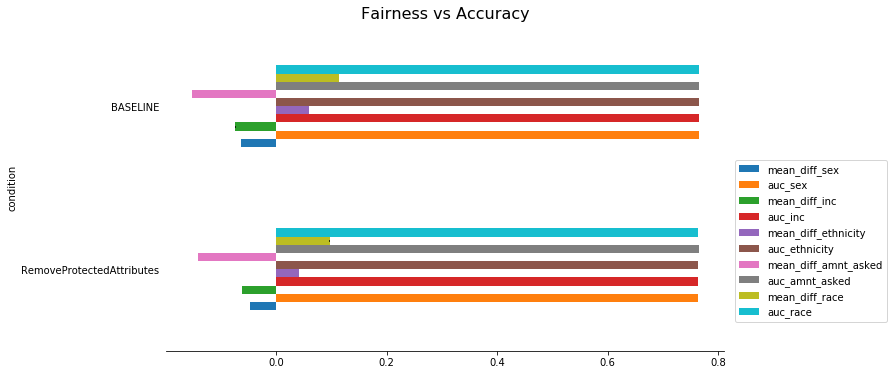

In [49]:
ax = mean_metrics.loc[reversed(["BASELINE", "RemoveProtectedAttributes"])].plot(
    kind="barh", figsize=(10, 6),xerr=stderr_metrics.loc[reversed(["BASELINE", "RemoveProtectedAttributes"])],
    legend=False);

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 0.6))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='y', which='both', left='off')
ax.set_title("Fairness vs Accuracy", fontsize=16);

In [6]:
mean_diff_sex = 0.062628 - 0.047233
mean_diff_sex

0.015395000000000006

In [7]:
mean_diff_inc = 0.073312 - 0.061552
mean_diff_inc

0.01176

In [8]:
mean_diff_ethnicity = 0.060018 - 0.042252
mean_diff_ethnicity

0.017766000000000004

In [9]:
mean_diff_amnt_asked = 0.152415 - 0.141652
mean_diff_amnt_asked

0.010762999999999995

In [11]:
mean_diff_race = 0.114489 - 0.096843
mean_diff_race

0.017645999999999995